### Identifying State Transitions in Melanoma During Drug-Induced Idling
C Heiser, Spring 2019  
  
---
The purpose of this work is to use cell lineage tracing via molecular barcodes and single-cell transcriptomic analyses to identify population-level heterogeneity and cell-state plasticity in BRAF-mutated melanoma (SKMEL5). 

Requirements:  
[`codyheiser/seq-tools/`](https://github.com/codyheiser/seq-tools)

In [1]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *
sys.path.append('../seq-tools/'); from seq_analysis import *

%matplotlib inline

Using TensorFlow backend.


---
Read in scRNA-seq data with associated barcode UMIs

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 32.8 s, sys: 5.97 s, total: 38.8 s
Wall time: 39.9 s


Normalize barcode counts within each scRNA-seq set 

In [3]:
U_RNA_counts = pd.DataFrame(U.barcode_counts(IDs='all'))
U_RNA_counts_norm = U_RNA_counts.div(U_RNA_counts.sum(axis=0), axis=1)

In [4]:
I_RNA_counts = pd.DataFrame(I.barcode_counts(IDs='all'))
I_RNA_counts_norm = I_RNA_counts.div(I_RNA_counts.sum(axis=0), axis=1)

Read in associated __Read 1__ barcode assay results files, where barcodes were extracted using  
[`codyheiser/seq-tools/seq_extraction.sh`](https://github.com/codyheiser/seq-tools)

In [5]:
%%time
U_R1 = pd.read_csv(gzip.open('untreated/2898-CH-1-CGAAACAT-GTTCAGAG_S1_R1_001.txt.gz'), sep='\t', header=None)
I_R1 = pd.read_csv(gzip.open('idling/2898-CH-2-GGCCACAT-GTTCAGAG_S2_R1_001.txt.gz'), sep='\t', header=None)

CPU times: user 13.8 s, sys: 734 ms, total: 14.5 s
Wall time: 14.9 s


Read in associated __Read 2__ barcode assay results files, where barcodes were extracted using  
[`codyheiser/seq-tools/seq_extraction.sh`](https://github.com/codyheiser/seq-tools)  
and [`codyheiser/seq-tools/rev_comp.sh`](https://github.com/codyheiser/seq-tools)

In [6]:
%%time
U_R2 = pd.read_csv(gzip.open('untreated/2898-CH-1-CGAAACAT-GTTCAGAG_S1_R2_001_REVCOMP.txt.gz'), sep='\t', header=None)
I_R2 = pd.read_csv(gzip.open('idling/2898-CH-2-GGCCACAT-GTTCAGAG_S2_R2_001_REVCOMP.txt.gz'), sep='\t', header=None)

CPU times: user 13 s, sys: 790 ms, total: 13.7 s
Wall time: 14 s


Now add UMIs from __Read 1__ and __Read 2__ to get totals

In [7]:
U_bc = U_R1.append(U_R2)
I_bc = I_R1.append(I_R2)

Count unique barcode abundances in untreated and idling datasets

In [8]:
U_bc_counts = pd.DataFrame(U_bc[0].value_counts())
U_bc_counts.rename(index=str, columns={0: "Count"}, inplace=True)

In [9]:
I_bc_counts = pd.DataFrame(I_bc[0].value_counts())
I_bc_counts.rename(index=str, columns={0: "Count"}, inplace=True)

Finally, convert counts to fractions of total to normalize for comparison with scRNA-seq data

In [10]:
U_bc_counts_norm = U_bc_counts.div(U_bc_counts.sum(axis=0), axis=1)
I_bc_counts_norm = I_bc_counts.div(I_bc_counts.sum(axis=0), axis=1)

---
Merge scRNA-seq and targeted barcode assay datasets on barcode and print overlay

In [11]:
U_totalcounts = U_RNA_counts_norm.merge(U_bc_counts_norm, left_index=True, right_index=True, how='inner')
U_totalcounts.rename(columns={'Barcode':'U_RNA', 'Count':'U_BC'}, inplace=True)

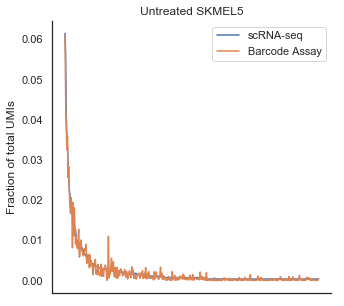

In [12]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(5,5))
U_totalcounts['U_RNA'].plot(label='scRNA-seq', legend=True)
U_totalcounts['U_BC'].plot(label='Barcode Assay', legend=True)
plt.title('Untreated SKMEL5')
plt.ylabel('Fraction of total UMIs')
sns.despine()
plt.show()

In [13]:
I_totalcounts = I_RNA_counts_norm.merge(I_bc_counts_norm, left_index=True, right_index=True, how='inner')
I_totalcounts.rename(columns={'Barcode':'I_RNA', 'Count':'I_BC'}, inplace=True)

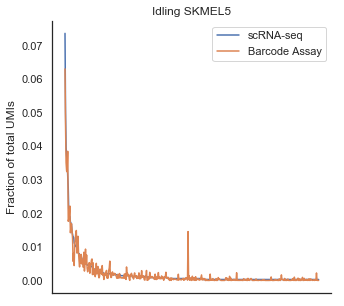

In [14]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(5,5))
I_totalcounts['I_RNA'].plot(label='scRNA-seq', legend=True)
I_totalcounts['I_BC'].plot(label='Barcode Assay', legend=True)
plt.title('Idling SKMEL5')
plt.ylabel('Fraction of total UMIs')
sns.despine()
plt.show()

Targeted barcode assay __corroborates barcode abundance__ from scRNA-seq results.  
We can confidently trust UMI counts for barcodes in RNA-seq data and use barcode subpopulations to investigate cell state transitions.

---
Perform dimensionality reduction on scRNA-seq results for _untreated_ (U) and _idling_ (I) SKMEL5 cells.